In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import math

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow
from keras import callbacks
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Flatten, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings("ignore")

2025-08-12 10:07:44.325057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754993264.709484      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754993264.811204      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
 df = pd.read_csv("/kaggle/input/traffic-flow-data/traffic.csv")

df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [4]:
df = df.drop(['ID'], axis=1)

df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


In [5]:
data = df.copy()

Text(0.5, 0, 'Date')

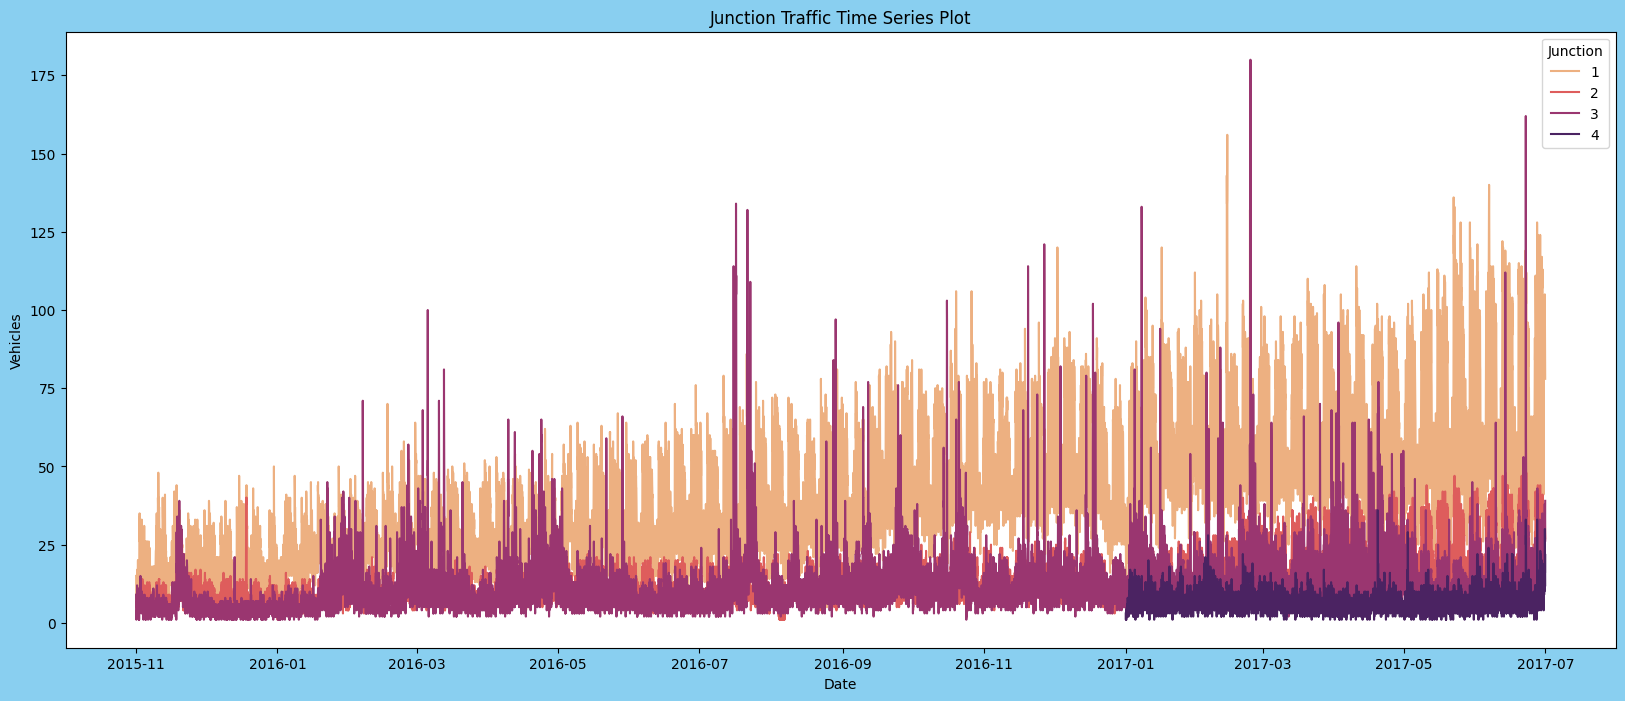

In [6]:
plt.figure(figsize=(20,8), facecolor="#89CFF0")

t_series = sns.lineplot(x=data['DateTime'], y='Vehicles', data=data, hue='Junction', palette='flare')
t_series.set_title("Junction Traffic Time Series Plot")
t_series.set_ylabel('Vehicles')
t_series.set_xlabel('Date')

In [7]:
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Date'] = data['DateTime'].dt.date
data['Hour'] =  data['DateTime'].dt.hour

data['Day'] = data.DateTime.dt.strftime('%A')

data.head()

,DateTime,Junction,Vehicles,Year,Month,Date,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,2015-11-01,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,2015-11-01,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,2015-11-01,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,2015-11-01,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,2015-11-01,4,Sunday


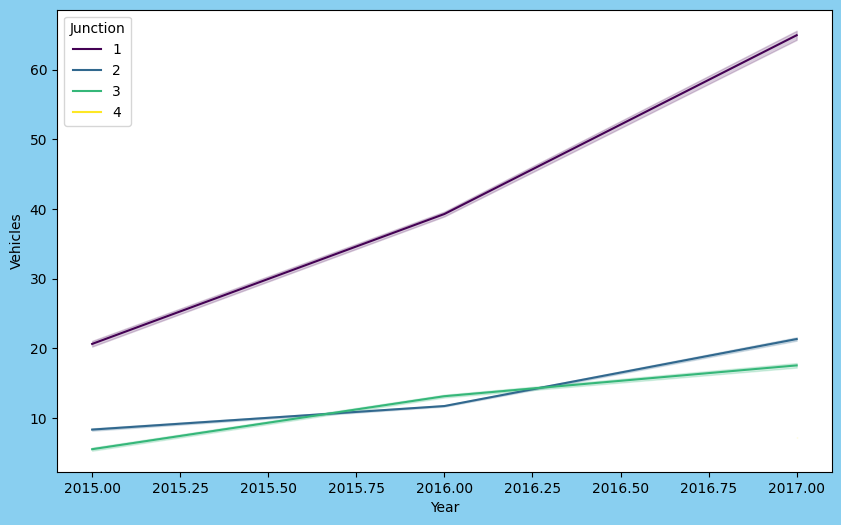

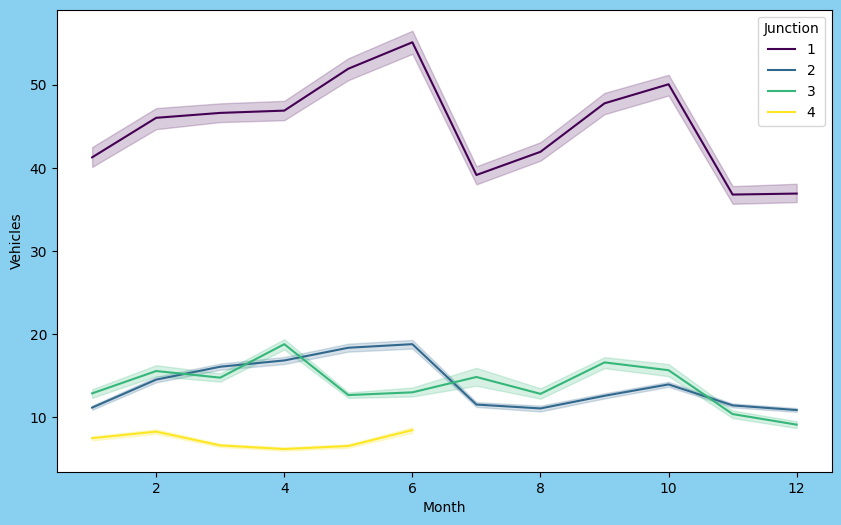

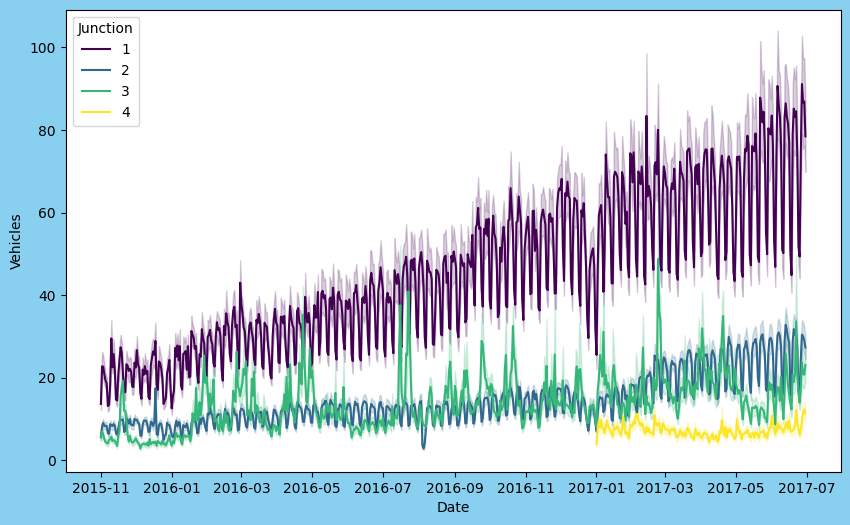

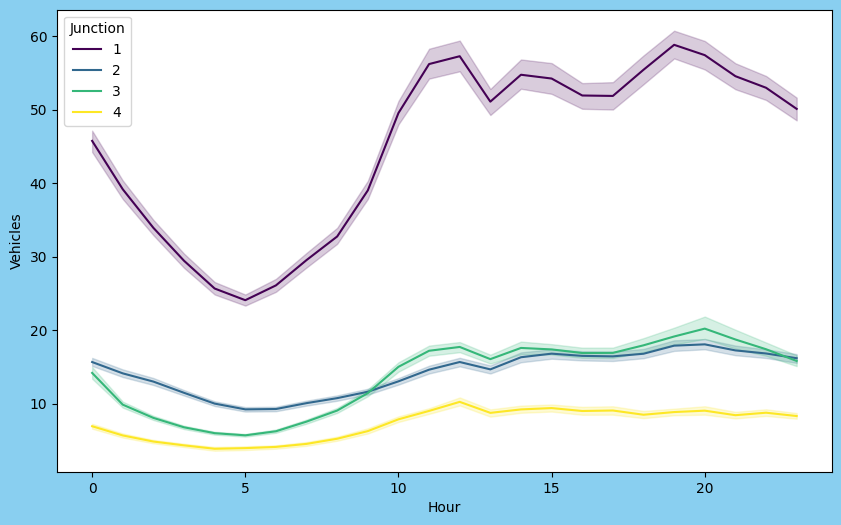

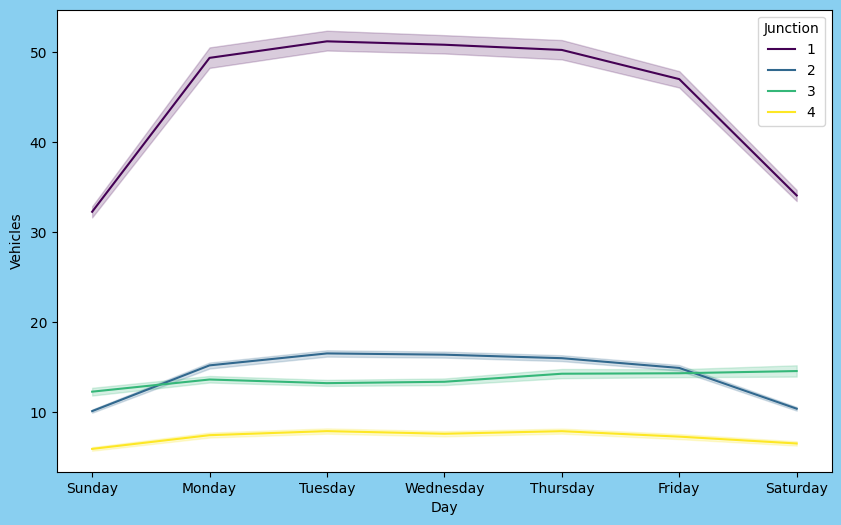

In [8]:
new_features = ['Year', 'Month', 'Date', 'Hour', 'Day']

for i in new_features:
    plt.figure(figsize=(10,6), facecolor='#89CFF0')
    ax = sns.lineplot(x=data[i], y='Vehicles', data=data, hue='Junction', palette='viridis')

Text(0.5, 0, 'Date')

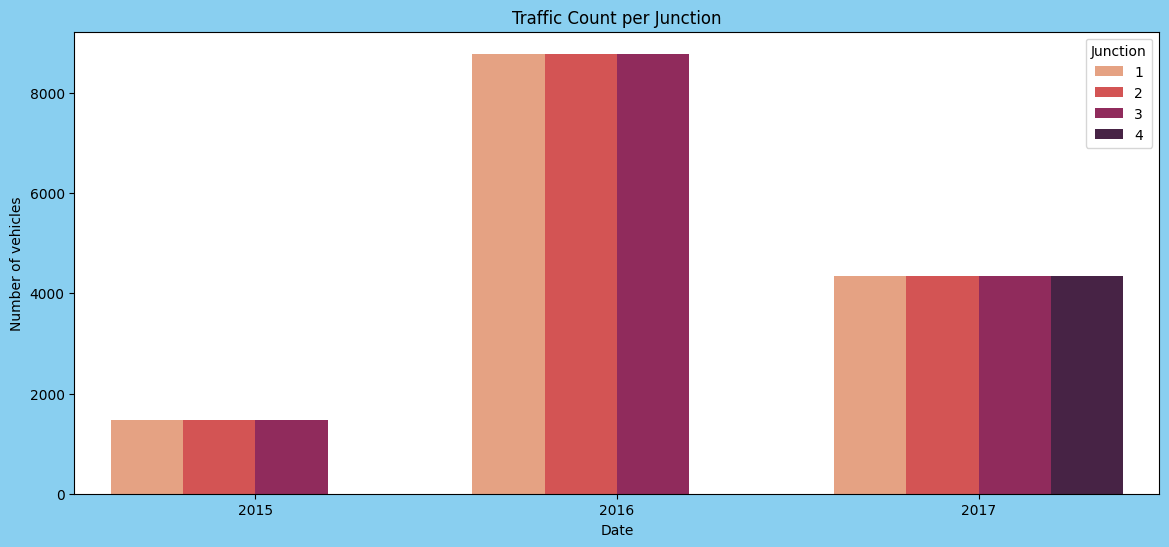

In [9]:
plt.figure(figsize=(14,6), facecolor='#89CFF0')

count = sns.countplot(data=data, x=data['Year'], hue='Junction', palette='rocket_r')

count.set_title('Traffic Count per Junction')
count.set_ylabel("Number of vehicles")
count.set_xlabel("Date")
